In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
#from visualization import visualize, display, sequence_identity
from rdkit.Chem import AllChem
from scipy.stats import spearmanr, ttest_ind

def get_accuracy_level(predicted_ECs, true_ECs):
    """
    based on a list of predicted_ECs, calculates the highest level of accuracy achieved
    """
    #convert true_EC to a list
    if type(predicted_ECs) == str:
        predicted_ECs = [predicted_ECs]
        
    if type(true_ECs) == str:
        true_ECs = [true_ECs]

    maxes = []
    for true_EC in true_ECs:

        true_split = true_EC.split('.')
        
        counters = []
        for predicted_EC in predicted_ECs:
            #print(true_EC)
            predicted_split = predicted_EC.split('.')
            counter = 0
            
            for predicted, true in zip(predicted_split, true_split):
                if predicted == true:
                    counter += 1
                else:
                    break
            counters.append(counter)
            #print(counters)
        
        maxes.append(np.max(counters))
    return maxes
#import umap

#supress warnings
import warnings
warnings.filterwarnings("ignore")

### results must be processed into the correct format as csvs under `results_summary`

In [37]:
task1_baselines = ['Random', 'CLEAN']
task1_splits = ['30', '30-50', 'price', 'promiscuous']

task2_baselines = ['Random', 'Similarity', 'CREEP', 'CREEP_text']
task2_splits = ['easy', 'medium', 'hard']

reference_EC_list = np.loadtxt('processed_data/EC_list.txt', dtype=str)
num_ECs = len(reference_EC_list)

In [38]:
#generate random baseline for each task and all splits
for task in ['task1', 'task2']:
    if task == 'task1':
        baselines = task1_baselines
        splits = task1_splits
        modality = 'protein'
    else:
        baselines = task2_baselines
        splits = task2_splits
        modality = 'reaction'

    for split in splits:
        query_df = pd.read_csv('{}_baselines/results_summary/{}/{}_{}_test_results_df.csv'.format(task, baselines[1], split, modality))
        if task == 'task1':
            num_cols = 3
        else:
            num_cols = len(query_df.columns) - num_ECs

        for i in range(query_df.shape[0]):
            np.random.seed(42)
            #shuffle the columns
            query_df.iloc[i, num_cols:] = query_df.iloc[i, num_cols:].sample(frac=1).values
        
        query_df.to_csv('{}_baselines/results_summary/{}/{}_{}_test_results_df.csv'.format(task, 'Random', split, modality), index=False)

In [41]:
results = pd.DataFrame(columns=['baseline', 'split', 'k', 'level 4 accuracy', 'level 3 accuracy', 'level 2 accuracy', 'level 1 accuracy'])

#load the query_df that's already been generated
task  = 'task2'

if task == 'task1':
    baselines = task1_baselines
    splits = task1_splits
    modality = 'protein'
else:
    baselines = task2_baselines
    splits = task2_splits
    modality = 'reaction'

for baseline in baselines:
    for split in splits:

        query_df = pd.read_csv('{}_baselines/results_summary/{}/{}_{}_test_results_df.csv'.format(task, baseline, split, modality)) #take a different baseline and randomize it
        if task == 'task1':
                num_cols = 3
        else:
            num_cols = len(query_df.columns) - num_ECs

        # query_df = pd.read_csv('{}_baselines/results_summary/{}/{}_{}_test_results_df.csv'.format(task, baseline, split, modality))
        # num_cols = sum(isinstance(name, str) for name in query_df.columns)
        # print(num_cols)
        #query_df = query_df.iloc[141:142,:]

        #collapse columns 0:3 into a single column list
        for k in [1, 5, 10]:
            query_df['predicted ECs'] = query_df.iloc[:, num_cols:num_cols+k].values.tolist()
            query_df['EC number list'] = query_df['EC number'].apply(lambda x: x.split(';'))
            
            query_df['k={} accuracy level'.format(k)] = query_df.apply(lambda x: get_accuracy_level(x['predicted ECs'],  x['EC number list']), axis=1)

        #make a k=1 retrieval accuracy table, broken down by accuracy greater than or equal to level 1, 2, 3, 4

        for k in [1, 5, 10]:
            accuracies = []
            for i in [4, 3, 2, 1]:
                exploded = query_df.explode('k={} accuracy level'.format(k))
                accuracy = exploded[exploded['k={} accuracy level'.format(k)] >= i].shape[0] / exploded.shape[0]
                accuracies.append(round(accuracy*100, 1))
                
            results.loc[len(results)] = [baseline, split, k, accuracies[0], accuracies[1], accuracies[2], accuracies[3]]

In [42]:
results

,baseline,split,k,level 4 accuracy,level 3 accuracy,level 2 accuracy,level 1 accuracy
0,Random,easy,1,0.0,0.0,0.6,13.6
1,Random,easy,5,0.0,0.6,6.2,50.8
2,Random,easy,10,0.0,4.5,18.1,82.5
3,Random,medium,1,0.0,1.1,1.7,16.4
4,Random,medium,5,0.0,2.3,11.3,57.1
5,Random,medium,10,0.0,4.5,23.7,83.6
6,Random,hard,1,0.0,1.2,1.2,24.5
7,Random,hard,5,0.0,3.7,4.3,48.5
8,Random,hard,10,0.0,6.7,11.0,73.6
9,Similarity,easy,1,60.5,78.0,87.0,93.2


In [43]:
results[results['k'] == 1].sort_values(by='split')

,baseline,split,k,level 4 accuracy,level 3 accuracy,level 2 accuracy,level 1 accuracy
0,Random,easy,1,0.0,0.0,0.6,13.6
9,Similarity,easy,1,60.5,78.0,87.0,93.2
18,CREEP,easy,1,48.0,70.6,84.2,93.2
27,CREEP_text,easy,1,60.5,87.0,93.2,97.7
6,Random,hard,1,0.0,1.2,1.2,24.5
15,Similarity,hard,1,0.0,0.0,14.7,43.6
24,CREEP,hard,1,1.8,9.2,27.6,62.0
33,CREEP_text,hard,1,2.5,12.9,31.9,61.3
3,Random,medium,1,0.0,1.1,1.7,16.4
12,Similarity,medium,1,0.0,40.1,56.5,75.7


# TODO: UPDATE REST OF THIS NOTEBOOK
Need to make it work for any test splits

easy_reaction_test reaction
k=1 accuracy: 0.0
k=10 accuracy: 0.0
k=96 accuracy: 0.0
average rank to find: 1841.15



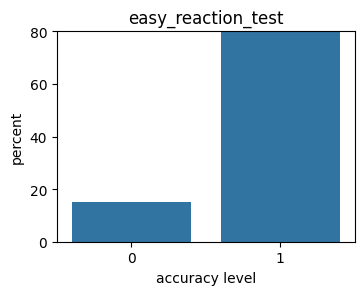

In [ ]:
plt.figure(figsize=(10, 8))

#datasets = ['protein2ec_easy_test', 'protein2ec_hard_test', 'protein2ec_price98_test']
datasets = ['easy_reaction_test']

results_df = pd.DataFrame(columns=['dataset', 'modality', 'metric', 'value'])

#directory = '240423'
counter = 0
for k, modality in enumerate(['reaction']): #['reaction', 'text', 'both']
    for j, dataset in enumerate(datasets):
        counter += 1

        query_df = pd.read_csv('../../splits/task2/{}.csv'.format(dataset))
        query_EC_list = query_df['EC number'].values
        # reference_df = pd.read_csv('/disk1/jyang4/repos/ProteinDT_submission/data/PECT/test_sets/all_ECs.csv')
        reference_EC_list = np.loadtxt('../../processed_data/EC_list.txt', dtype=str)

        #indices = np.load('/disk1/jyang4/repos/ProteinDT_submission/output/ProteinDT/240423/retrieval_results/{}_reaction2protein_retrieval_indices.npy')

        if 'protein' in dataset:
            #reaction_similarities = np.load('output/easy_split/retrieval_results/{}_reaction2protein_retrieval_similarities.npy'.format(dataset))
            #text_similarities = np.load('/disk1/jyang4/repos/ProteinDT_submission/output/ProteinDT/{}/retrieval_results/{}_protein2text_retrieval_similarities.npy'.format(directory, dataset))
            pass
        else:
            reaction_similarities = np.load('output/easy_split/retrieval_results/{}_reaction2protein_retrieval_similarities.npy'.format(dataset))
            text_similarities = np.load('output/easy_split/retrieval_results/{}_text2protein_retrieval_similarities.npy'.format(dataset))

        accuracies_k1 = []
        accuracies_k10 = []
        accuracies_k96 = []
        predicted_ECs = []
        rankings = []

        for i, query_EC in enumerate(query_EC_list):
            reaction_similarity = reaction_similarities[i]
            text_similarity = text_similarities[i]
            df = pd.DataFrame({'EC': reference_EC_list, 'reaction similarity': reaction_similarity, 'text similarity': text_similarity})
            df['reaction rank'] = df['reaction similarity'].rank(ascending=False)
            df['text rank'] = df['text similarity'].rank(ascending=False)
            
            if modality == 'reaction':
                df['rank'] = df['reaction rank']
            elif modality == 'text':
                df['rank'] = df['text rank']
            elif modality == 'both':
                df['rank'] = (df['reaction rank'] + df['text rank']) / 2

            df = df.sort_values('rank').reset_index()
            top_EC = df['EC'].values[:96]
            accuracies_k1.append(query_EC in top_EC[:1])
            accuracies_k10.append(query_EC in top_EC[:10])
            accuracies_k96.append(query_EC in top_EC)
            predicted_ECs.append(top_EC[0])
            rankings.append(df[df['EC'] == query_EC].index[0] + 1)
            
        accuracies_k1 = np.array(accuracies_k1)
        accuracies_k10 = np.array(accuracies_k10)
        accuracies_k96 = np.array(accuracies_k96)
        rankings = np.array(rankings)

        #add to the last row of the results_df
        results_df.loc[len(results_df.index)] = [dataset, modality, 'k=1', np.mean(accuracies_k1)]
        results_df.loc[len(results_df.index)] = [dataset, modality, 'k=10', np.mean(accuracies_k10)]
        results_df.loc[len(results_df.index)] = [dataset, modality, 'k=96', np.mean(accuracies_k96)]
        results_df.loc[len(results_df.index)] = [dataset, modality, 'rank to find', np.mean(rankings)]

        print(dataset + " " + modality)
        print('k=1 accuracy:', np.mean(accuracies_k1))
        print('k=10 accuracy:', np.mean(accuracies_k10))
        print('k=96 accuracy:', np.mean(accuracies_k96))
        print('average rank to find:', np.mean(rankings))
        print('')
        
        query_df['predicted_EC'] = predicted_ECs
        query_df['rankings'] = rankings
        query_df['accuracy@1'] = accuracies_k1
        query_df['accuracy@10'] = accuracies_k10
        query_df['accuracy@96'] = accuracies_k96

        query_df['accuracy level'] = query_df.apply(lambda x: get_accuracy_level(x['predicted_EC'],  x['EC number']), axis=1)

        plt.subplot(3, 3, counter)
        plt.title(dataset)
        sns.countplot(data=query_df, x='accuracy level', stat='percent')
        if 'protein' in dataset:
            plt.ylim(0, 60)
        else:
            plt.ylim(0, 80)
plt.tight_layout()

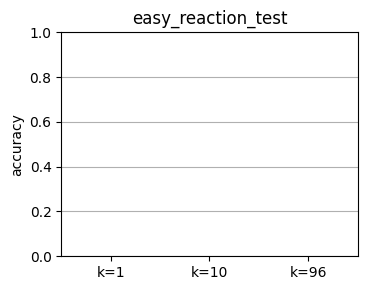

In [ ]:
plt.figure(figsize=(10, 3))
results_df1 = results_df[results_df['metric'] != 'rank to find']

for i, dataset in enumerate(datasets):
    plt.subplot(1, 3, i + 1)
    plt.title(dataset)
    if i != 2:
        sns.barplot(data=results_df1[results_df1['dataset'] == dataset], x='metric', y='value', hue='modality', hue_order=['text', 'reaction', 'both'], legend=False)
    else:
        sns.barplot(data=results_df1[results_df1['dataset'] == dataset], x='metric', y='value', hue_order=['text', 'reaction', 'both'],  hue='modality')
    plt.ylim(0, 1)
    plt.ylabel('accuracy')
    plt.xlabel(None)
    plt.grid(axis='y')
    #sns.barplot(data=results_df, x='metric', y='value', hue='dataset')
plt.tight_layout()

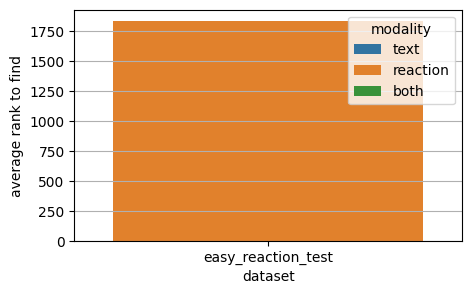

In [ ]:
plt.figure(figsize=(5, 3))
results_df2 = results_df[results_df['metric'] == 'rank to find']
sns.barplot(data=results_df2, x='dataset', y='value', hue_order=['text', 'reaction', 'both'],  hue='modality')
plt.ylabel('average rank to find')
#add horizontal grid lines
#plt.ylim(0, 250)
plt.grid(axis='y')

### Visualize reactions that were correctly and incorrectly identified

Tryptophanase
4.1.99.1


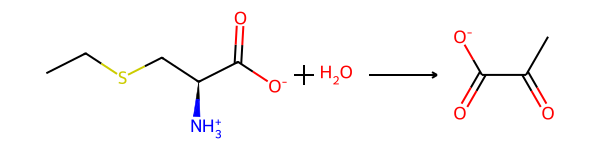

In [ ]:
index = 9

#print the reaction from the test set
print(df['name'].values[index])
EC_num = df['brenda'].values[index]
print(EC_num)
AllChem.ReactionFromSmarts(ec2react_test[EC_num], useSmiles=True)

14


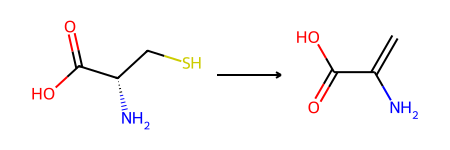

In [ ]:
#print the reaction(s) from the train set
rxns = ec2react_train[EC_num]
print(len(rxns))
AllChem.ReactionFromSmarts(rxns[0], useSmiles=True)

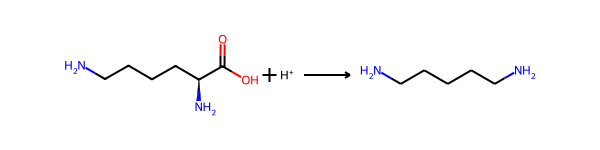

In [ ]:
AllChem.ReactionFromSmarts(rxns[1], useSmiles=True)

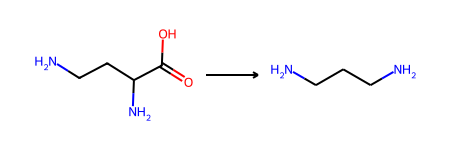

In [ ]:
AllChem.ReactionFromSmarts(rxns[2], useSmiles=True)

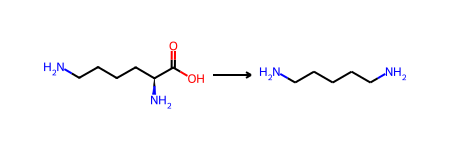

In [ ]:
AllChem.ReactionFromSmarts(rxns[3], useSmiles=True)

### Measure similarity to existing embeddings

In [ ]:
embeddings = np.load('/disk1/jyang4/repos/ProteinDT_submission/output/ProteinDT/240423/step_02_extract_representation/all_reactions_representations.npy', allow_pickle=True).item()['reaction_repr_array']
metadata = pd.read_csv('/disk1/jyang4/repos/ProteinDT_submission/data/PECT/test_sets/all_reactions.csv')

In [ ]:
len(ec2react_train_reactions)

44150

Checking for duplicates

In [ ]:
#print duplicated rows in metadata
duplicated_reaction = metadata[metadata.duplicated(subset='reaction_smiles')]['reaction_smiles'].values[1]
metadata[metadata['reaction_smiles'] == duplicated_reaction]

,brenda,reaction_smiles
66,1.1.1.1,CCO.NC(=O)c1ccc[n+]([C@@H]2O[C@H](COP(=O)(O)OP...
392,1.1.1.103,CCO.NC(=O)c1ccc[n+]([C@@H]2O[C@H](COP(=O)(O)OP...
432,1.1.1.11,CCO.NC(=O)c1ccc[n+]([C@@H]2O[C@H](COP(=O)(O)OP...
1122,1.1.1.202,CCO.NC(=O)c1ccc[n+]([C@@H]2O[C@H](COP(=O)(O)OP...
1492,1.1.1.244,CCO.NC(=O)c1ccc[n+]([C@@H]2O[C@H](COP(=O)(O)OP...
2646,1.1.1.73,CCO.NC(=O)c1ccc[n+]([C@@H]2O[C@H](COP(=O)(O)OP...


In [ ]:
merged['reaction_smiles'].isin(ec2react_train_reactions).sum()

0

In [ ]:
merged['reaction_smiles'].isin(ec2react_train_reactions).sum()

0

In [ ]:
embeddings.shape

(46983, 256)

In [ ]:
46983-43413

3570

In [ ]:
metadata.drop_duplicates(subset='reaction_smiles')

,brenda,reaction_smiles
0,1.1.1.1,CCCCC[C@@H](C)O.NC(=O)c1ccc[n+]([C@@H]2O[C@H](...
1,1.1.1.1,CCCCCCC(C)=O.NC(=O)C1=CN([C@@H]2O[C@H](COP(=O)...
2,1.1.1.1,CC(=O)CC(C)=O.NC(=O)C1=CN([C@@H]2O[C@H](COP(=O...
3,1.1.1.1,CC(=O)C(C)=O.NC(=O)C1=CN([C@@H]2O[C@H](COP(=O)...
4,1.1.1.1,CC(O)c1ccccc1.NC(=O)c1ccc[n+]([C@@H]2O[C@H](CO...
...,...,...
46978,7.5.2.9,Nc1ncnc2c1ncn2[C@@H]1O[C@H](COP(=O)([O-])OP(=O...
46979,7.6.2.10,*OP(=O)([O-])OC[C@H](O)CO.Nc1ncnc2c1ncn2[C@@H]...
46980,7.6.2.5,C=CC1=C(C)C2=Cc3c(C=C)c(C)c4n3[Fe-2]35n6c(c(C)...
46981,7.6.2.8,CC1=C2[N+]3=C(C=C4[N+]5=C(C(C)=C6N7[C@@H]8[C@H...


### Find most similar reactions in the training set. 

Alternatively extract DRFP instead as a fixed fingerprint?

In [ ]:
#loop through keys and pool values in ec2react_train
ec2react_train_reactions = []
for k in ec2react_train.keys():
    ec2react_train_reactions.extend(ec2react_train[k])

train_metadata = metadata[metadata['reaction_smiles'].isin(ec2react_train_reactions)]
test_metadata = metadata[~metadata['reaction_smiles'].isin(ec2react_train_reactions)]

#seems like I might need to normalize the vectors to compute similiartiy?
def get_similarity(brenda, query_reaction):
    train_indices = train_metadata.index

    #not sure why I can't use test_metadata here
    #query_index = metadata[metadata['reaction_smiles'] == query_reaction].index[0]
    query_index = test_metadata[test_metadata['reaction_smiles'] == query_reaction].index[0]

    #get the embeddings for the train and test reactions
    train_embeddings = embeddings[train_indices]
    query_embedding = embeddings[query_index]

    #find the most similar embedding in the train set
    similarities = np.dot(train_embeddings, query_embedding)

    #return index of the highest similarity
    argmax_similarity = np.argmax(similarities)
    index = train_indices[argmax_similarity]
    smiliar_reaction = metadata.loc[index, 'reaction_smiles']
    

    #return the highest similarity
    return pd.Series([max(similarities), smiliar_reaction])

In [ ]:
#apply get similarity to merged
merged[['similarity', 'most_similar_smiles']] = merged.apply(lambda x: get_similarity(x['brenda'], x['reaction_smiles']), axis=1)

In [ ]:
merged['most_similar_ECs'] = merged['most_similar_smiles'].apply(lambda x: react2ec[x])
merged

,brenda,reaction_smiles,predicted_EC,rankings,correct,num_reactions,similarity,most_similar_smiles,most_similar_ECs
0,2.3.1.188,COc1cc(/C=C/C(=O)SCCNC(=O)CCNC(=O)[C@H](O)C(C)...,2.3.1.75,20,False,1,14.875000,CCCCCCCC/C=C\CCCCCCCC(=O)SCCNC(=O)CCNC(=O)[C@H...,"[2.3.1.76, 2.3.1.75]"
1,1.13.11.43,COc1cc(C=Cc2ccc(O)c(OC)c2)ccc1O.O=O>>COc1cc(C=...,1.14.18.1,144,False,1,15.554688,COc1cc(CCN)ccc1O.O.O=O>>COc1cc(CC=O)ccc1O,[1.4.3.4]
2,2.4.1.342,Nc1ncnc2c1ncn2[C@@H]1O[C@H](COP(=O)([O-])OP(=O...,2.7.1.167,17,False,1,15.156250,Nc1ncnc2c1ncn2[C@@H]1O[C@H](COP(=O)([O-])OP(=O...,[2.7.7.27]
3,2.5.1.6,C[Se]CCC(N)C(=O)O.Nc1ncnc2c1ncn2[C@@H]1O[C@H](...,1.4.99.6,809,False,1,12.234375,C[C@H](N)C(=O)O.NC(=O)CC[C@H](N)C(=O)O.Nc1ncnc...,[6.3.2.49]
4,5.3.1.31,O=S(=O)([O-])C[C@H]1OC(O)[C@H](O)[C@@H](O)[C@@...,5.3.1.8,8,True,1,19.875000,O=P(O)(O)OC[C@H]1OC(O)[C@H](O)[C@H](O)[C@@H]1O...,[5.3.1.6]
...,...,...,...,...,...,...,...,...,...
509,2.3.1.270,*C(O)CC(=O)NC(CCCN)C(=O)O.*CCC(=O)S*>>*C(=O)OC...,2.3.1.85,326,False,1,10.492188,*C(=O)OC[C@@H](O)COP(=O)([O-])[O-].*CCC(=O)S*>...,[2.3.1.51]
510,4.2.1.31,O.O=C([O-])/C=C\C(=O)[O-]>>O=C(O)CC(O)C(=O)O,4.2.1.2,9,True,1,14.898438,O.O=C(O)/C=C(/CC(=O)O)C(=O)O>>O=C(O)C[C@H](C(=...,"[4.2.1.99, 4.2.1.3]"
511,2.7.1.92,Nc1ncnc2c1ncn2[C@@H]1O[C@H](COP(=O)([O-])OP(=O...,2.7.1.58,5,True,1,13.476562,Nc1ncnc2c1ncn2[C@@H]1O[C@H](COP(=O)([O-])OP(=O...,"[2.7.1.178, 2.7.1.58]"
512,1.12.98.2,CC1Nc2nc(N)[nH]c(=O)c2N2CN(c3ccc(CC(O)C(O)C(O)...,4.2.1.147,341,False,1,13.843750,O=C([O-])CCCCCC1NC(=O)NC1CS>>O=C([O-])CCCC[C@@...,[2.8.1.6]


In [ ]:
merged['accuracy level'] = merged.apply(lambda x: get_accuracy_level(x['predicted_EC'],  x['brenda']), axis=1)
merged['accuracy level baseline'] = merged.apply(lambda x: get_accuracy_level(x['most_similar_ECs'], x['brenda']), axis=1)

In [ ]:
merged

,brenda,reaction_smiles,predicted_EC,rankings,correct,num_reactions,similarity,most_similar_smiles,most_similar_ECs,accuracy level,accuracy level baseline
0,2.3.1.188,COc1cc(/C=C/C(=O)SCCNC(=O)CCNC(=O)[C@H](O)C(C)...,2.3.1.75,20,False,1,14.875000,CCCCCCCC/C=C\CCCCCCCC(=O)SCCNC(=O)CCNC(=O)[C@H...,"[2.3.1.76, 2.3.1.75]",3,0
1,1.13.11.43,COc1cc(C=Cc2ccc(O)c(OC)c2)ccc1O.O=O>>COc1cc(C=...,1.14.18.1,144,False,1,15.554688,COc1cc(CCN)ccc1O.O.O=O>>COc1cc(CC=O)ccc1O,[1.4.3.4],1,1
2,2.4.1.342,Nc1ncnc2c1ncn2[C@@H]1O[C@H](COP(=O)([O-])OP(=O...,2.7.1.167,17,False,1,15.156250,Nc1ncnc2c1ncn2[C@@H]1O[C@H](COP(=O)([O-])OP(=O...,[2.7.7.27],1,1
3,2.5.1.6,C[Se]CCC(N)C(=O)O.Nc1ncnc2c1ncn2[C@@H]1O[C@H](...,1.4.99.6,809,False,1,12.234375,C[C@H](N)C(=O)O.NC(=O)CC[C@H](N)C(=O)O.Nc1ncnc...,[6.3.2.49],0,0
4,5.3.1.31,O=S(=O)([O-])C[C@H]1OC(O)[C@H](O)[C@@H](O)[C@@...,5.3.1.8,8,True,1,19.875000,O=P(O)(O)OC[C@H]1OC(O)[C@H](O)[C@H](O)[C@@H]1O...,[5.3.1.6],3,3
...,...,...,...,...,...,...,...,...,...,...,...
509,2.3.1.270,*C(O)CC(=O)NC(CCCN)C(=O)O.*CCC(=O)S*>>*C(=O)OC...,2.3.1.85,326,False,1,10.492188,*C(=O)OC[C@@H](O)COP(=O)([O-])[O-].*CCC(=O)S*>...,[2.3.1.51],3,3
510,4.2.1.31,O.O=C([O-])/C=C\C(=O)[O-]>>O=C(O)CC(O)C(=O)O,4.2.1.2,9,True,1,14.898438,O.O=C(O)/C=C(/CC(=O)O)C(=O)O>>O=C(O)C[C@H](C(=...,"[4.2.1.99, 4.2.1.3]",3,0
511,2.7.1.92,Nc1ncnc2c1ncn2[C@@H]1O[C@H](COP(=O)([O-])OP(=O...,2.7.1.58,5,True,1,13.476562,Nc1ncnc2c1ncn2[C@@H]1O[C@H](COP(=O)([O-])OP(=O...,"[2.7.1.178, 2.7.1.58]",3,0
512,1.12.98.2,CC1Nc2nc(N)[nH]c(=O)c2N2CN(c3ccc(CC(O)C(O)C(O)...,4.2.1.147,341,False,1,13.843750,O=C([O-])CCCCCC1NC(=O)NC1CS>>O=C([O-])CCCC[C@@...,[2.8.1.6],0,0


Visualize some of the reactions with highest and lowest similarity

In [ ]:
merged_sorted = merged.sort_values('similarity', ascending=False)
merged_sorted

,brenda,reaction_smiles,predicted_EC,rankings,correct,num_reactions,similarity,most_similar_smiles,most_similar_ECs,accuracy level,accuracy level baseline
252,1.8.5.2,O=S(=O)([O-])S>>O=S(=O)([O-])SSS(=O)(=O)[O-],2.8.1.1,96,False,1,34.156250,O=S(=O)([O-])S.[Fe+3]>>O=S(=O)([O-])SSS(=O)(=O...,[1.8.2.2],0,2
36,1.97.1.9,O=[Se](=O)([O-])[O-].[H]*[H]>>O=[Se]([O-])[O-],1.8.3.1,221,False,1,23.703125,O=S(=O)([O-])[S-]>>O=S([O-])[O-],[2.8.1.1],1,0
485,4.99.1.6,O/N=C/Cc1c[nH]c2ccccc12>>N#CCc1c[nH]c2ccccc12,4.1.2.10,524,False,1,23.437500,O/N=C\Cc1ccccc1>>N#CCc1ccccc1,[4.99.1.7],1,3
164,2.1.1.n4,C[S+](CC[C@H]([NH3+])C(=O)[O-])C[C@H]1O[C@@H](...,2.5.1.114,3,True,1,22.359375,C[S+](CCC(N)C(=O)O)CC1OC(n2cnc3c(N)ncnc32)C(O)...,[2.1.1.9],1,3
326,2.3.1.268,CC(=O)SCCNC(=O)CCNC(=O)[C@H](O)C(C)(C)COP(=O)(...,2.3.1.84,46,False,1,21.812500,CC(=O)SCCNC(=O)CCNC(=O)[C@H](O)C(C)(C)COP(=O)(...,"[3.1.1.1, 2.3.1.84]",3,1
...,...,...,...,...,...,...,...,...,...,...,...
467,2.4.1.26,*OP(=O)([O-])OC[C@H]1O[C@@H](n2cc(CO)c(N)nc2=O...,3.2.2.17,76,False,1,10.453125,C/C(=C\CNc1ncnc2[nH]cnc12)CO.O=c1ccn([C@@H]2O[...,[2.4.1.203],0,3
225,1.14.99.54,*[C@@H]1O[C@H](CO)[C@@H](O[C@@H]2O[C@H](CO)[C@...,1.14.18.10,12,False,1,10.171875,OC[C@H]1O[C@H](O[C@@H]2[C@@H](CO)O[C@H](O[C@@H...,"[2.4.1.25, 3.2.1.33]",2,0
229,1.1.1.385,NC(=O)c1ccc[n+]([C@@H]2O[C@H](COP(=O)([O-])OP(...,1.1.1.206,19,False,1,9.992188,CC(C)[C@@](O)(CC(=O)[O-])C(=O)[O-].NC(=O)c1ccc...,"[1.1.1.85, 2.6.1.42, 4.2.1.33]",3,0
102,3.4.17.3,*[C@H]([NH3+])C(=O)[O-].[20FH]>>*[NH2+]C(*)C(*)=O,4.2.2.25,255,False,1,9.828125,CC(C)[N+](=O)[O-].O>>CC(C)=O,[1.7.3.1],0,0


In [ ]:
merged_sorted['rankings'].mean()

166.20622568093384

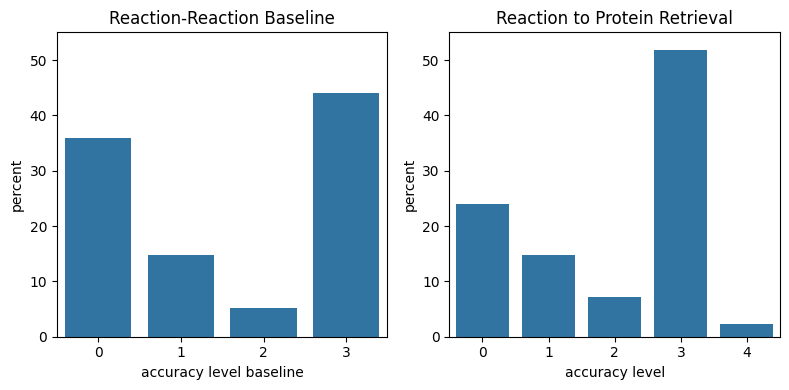

In [ ]:
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
sns.countplot(data=merged_sorted, x='accuracy level baseline', stat='percent')
plt.ylim(0, 55)
plt.title('Reaction-Reaction Baseline')

plt.subplot(1, 2, 2)
sns.countplot(data=merged_sorted, x='accuracy level', stat='percent')
plt.ylim(0, 55)
plt.title('Reaction to Protein Retrieval')
plt.tight_layout()

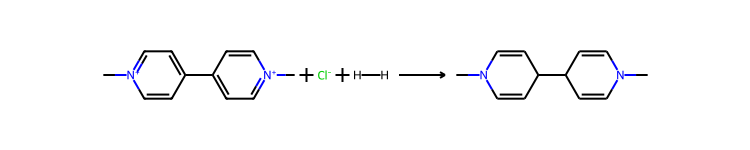

In [ ]:
index=5
rxn = merged_sorted['reaction_smiles'].values[index]
AllChem.ReactionFromSmarts(rxn, useSmiles=True)

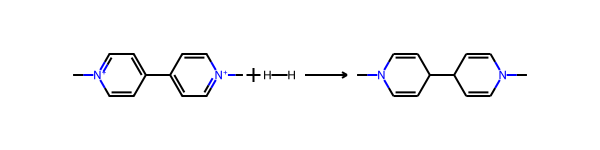

In [ ]:
rxn = merged_sorted['most_similar_smiles'].values[index]
AllChem.ReactionFromSmarts(rxn, useSmiles=True)

Ttest_indResult(statistic=3.0597745480205303, pvalue=0.0023311446105753033)


<Axes: xlabel='correct', ylabel='similarity'>

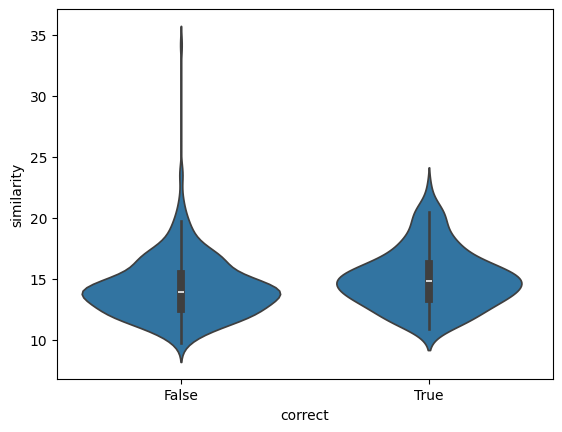

In [ ]:
#calculate the correlation between correct and reaction similarity
#print(spearmanr(merged['reaction_similarity'],merged['correct']))
print(ttest_ind(merged[merged['correct']]['similarity'], merged[~merged['correct']]['similarity']))
sns.violinplot(data=merged, x='correct', y='similarity')

<Axes: xlabel='num_reactions', ylabel='Percent'>

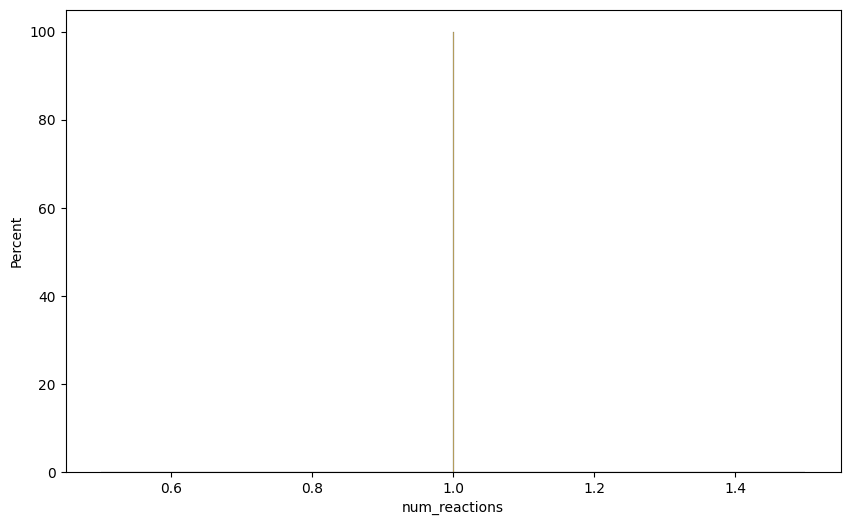

In [ ]:
#plot the disitrbution of correct and incorrect, broken down by the len of the values
merged['num_reactions'] = merged['brenda'].apply(lambda x: len(ec2react[x]))
plt.figure(figsize=(10, 6))
#convert correct to categorical
#merged['correct'] = merged['correct'].astype('category')

correct = merged[merged['rankings'] <= 10]
incorrect = merged[merged['rankings'] > 10]

sns.histplot(correct, x='num_reactions', bins=1000, alpha=0.5, stat='percent')
sns.histplot(incorrect, x='num_reactions', bins=1000, color='orange', alpha=0.5, stat='percent')
#plt.xlim(0, 100)

The ones with more reactions in the training set are slightly likely to be more correctly predicted

SignificanceResult(statistic=0.19554093426013563, pvalue=1.0011081297078748e-26)


<Axes: xlabel='correct', ylabel='num_reactions'>

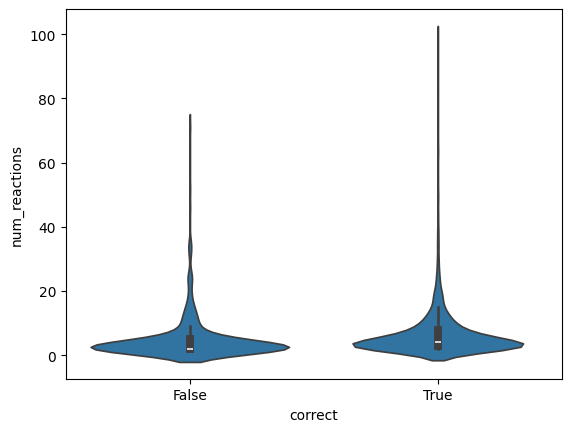

In [ ]:
#drop rows where merged > 100
merged_filtered = merged[merged['num_reactions'] <= 100]
print(spearmanr(merged_filtered['num_reactions'],merged_filtered['correct']))
sns.violinplot(data=merged_filtered, x='correct', y='num_reactions')

SignificanceResult(statistic=0.17655503243428985, pvalue=5.165447531987063e-22)


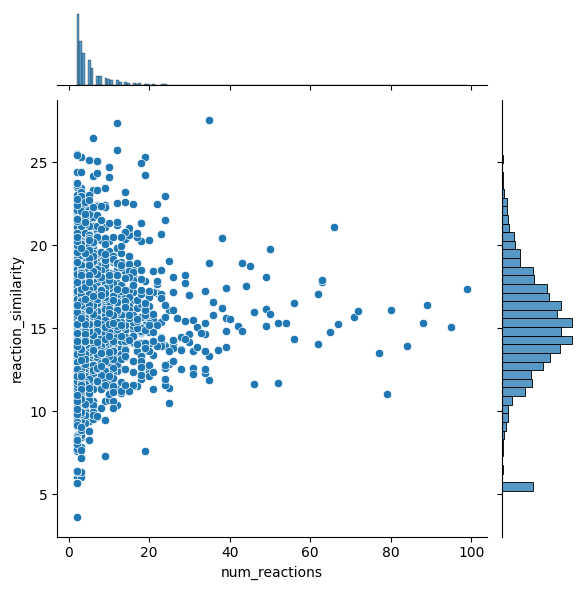

In [ ]:
print(spearmanr(merged_filtered['num_reactions'],merged_filtered['reaction_similarity']))
sns.jointplot(data=merged_filtered, x='num_reactions', y='reaction_similarity')